# RESUME-JOB MATCHING USING A DATASET

In [1]:
!pip install tensorflow -qq

In [2]:
!pip install datasets -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install xgboost==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [ ]:
!curl -X GET \
     "https://datasets-server.huggingface.co/rows?dataset=cnamuangtoun%2Fresume-job-description-fit&config=default&split=train&offset=0&length=100"

{"features":[{"feature_idx":0,"name":"resume_text","type":{"dtype":"string","_type":"Value"}},{"feature_idx":1,"name":"job_description_text","type":{"dtype":"string","_type":"Value"}},{"feature_idx":2,"name":"label","type":{"dtype":"string","_type":"Value"}}],"rows":[{"row_idx":0,"row":{"resume_text":"SummaryHighly motivated Sales Associate with extensive customer service and sales experience. Outgoing sales professional with track record of driving increased sales, improving buying experience and elevating company profile with target market.\nHighlights-Soft Skills: Public Speaking, Public Relations, Team Building, Project Management, Procedure writing, Staff Supervision and Management, Ability to interface with professionals on all levels. Accomplishments, Honors, and Activities -Board of Directors Member for the Food Bank of Corpus Christi from November 2010 to April 2013. -Held Life Insurance License -Basketball Official (Referee) High School Varsity Level.\nExperienceAccountant,08

In [4]:
from datasets import load_dataset

ds = load_dataset("cnamuangtoun/resume-job-description-fit")

# Shuffle the dataset
ds = ds.shuffle(seed=42)

train_ds = ds["train"]
test_ds = ds["test"]

train.csv:   0%|          | 0.00/53.4M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1759 [00:00<?, ? examples/s]

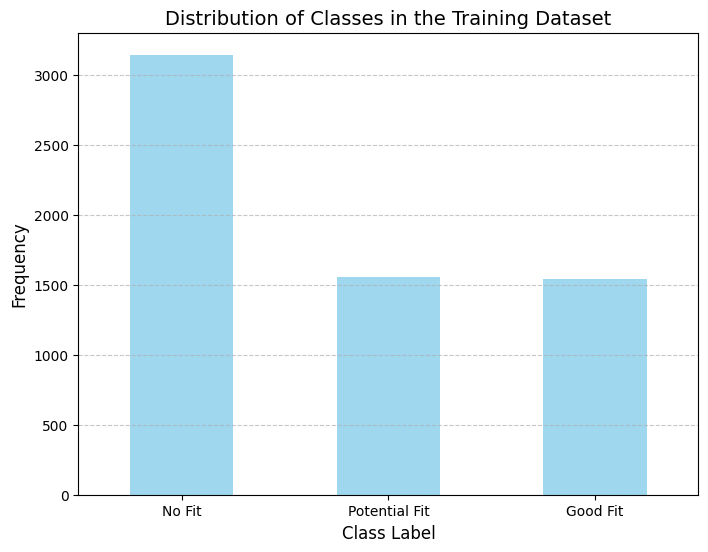

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

label_series = pd.Series(train_ds['label'])
label_mapping = {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
numeric_labels = label_series.map(label_mapping)

plt.figure(figsize=(8, 6))
numeric_labels.value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Distribution of Classes in the Training Dataset', fontsize=14)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(ticks=range(len(label_mapping)), labels=label_mapping.keys(), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


This shows that the Potential and Good Fit is highly imbalanced and the No Fit class is over represented. This dataset could benefit from oversampling the two classes to avoid overfitting the dataset to only predict No Fit


# Oversampling

In [ ]:
ds.shape

{'train': (6241, 3), 'test': (1759, 3)}

In [6]:
import pandas as pd
train_ds = pd.DataFrame(train_ds)
print(type(train_ds['label']))

<class 'pandas.core.series.Series'>


In [7]:
from sklearn.utils import resample

# Check class distributions
no_fit = train_ds[train_ds['label'] == 'No Fit']
potential_fit = train_ds[train_ds['label'] == 'Potential Fit']
good_fit = train_ds[train_ds['label'] == 'Good Fit']

# Handle empty or small classes
if len(potential_fit) > 0:
    potential_fit_oversampled = resample(potential_fit, replace=True, n_samples=len(no_fit), random_state=42)
else:
    potential_fit_oversampled = pd.DataFrame()

if len(good_fit) > 0:
    good_fit_oversampled = resample(good_fit, replace=True, n_samples=len(no_fit), random_state=42)
else:
    good_fit_oversampled = pd.DataFrame()

# Combine the datasets
balanced_train_df = pd.concat([no_fit, potential_fit_oversampled, good_fit_oversampled])
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print(balanced_train_df['label'].value_counts())


label
No Fit           3143
Good Fit         3143
Potential Fit    3143
Name: count, dtype: int64


In [8]:
label_series = pd.Series(balanced_train_df['label'])
label_mapping = {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
numeric_labels = label_series.map(label_mapping)

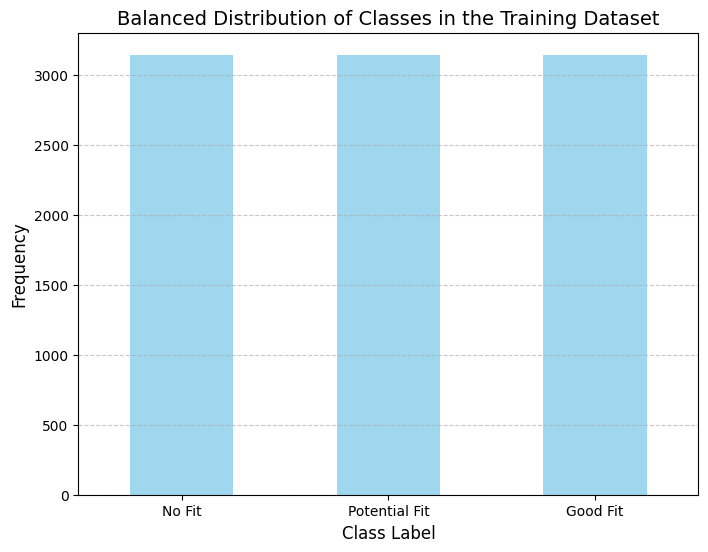

In [9]:
# Plot the distribution using the numeric labels
plt.figure(figsize=(8, 6))
numeric_labels.value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Balanced Distribution of Classes in the Training Dataset', fontsize=14)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(ticks=range(len(label_mapping)), labels=label_mapping.keys(), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(balanced_train_df, test_size=0.2, random_state=42)

ds["train"] = train_df
ds["validation"] = valid_df
# Print the sizes of the splits for verification
print(f"Train dataset size: {len(ds['train'])}")
print(f"Validation dataset size: {len(ds['validation'])}")
print(f"Test dataset size: {len(ds['test'])}")

Train dataset size: 7543
Validation dataset size: 1886
Test dataset size: 1759


In [11]:
train_ds = ds['train']
test_ds = ds['test']
val_ds = ds['validation']

In [ ]:
print(type(train_ds))

<class 'pandas.core.frame.DataFrame'>


In [22]:
print(train_ds.iloc[0])

resume_text             Professional SummaryQuality-driven leader: suc...
job_description_text    LHH Recruitment Solutions is partnering with a...
label                                                              No Fit
combined_text           Professional SummaryQuality-driven leader: suc...
Name: 5167, dtype: object


In [ ]:
print(type(test_ds))

<class 'datasets.arrow_dataset.Dataset'>


# TRANSFORMER

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configuration
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32
max_length = 600

# Label mapping
label_map = {"Good Fit": 2, "Potential Fit": 1, "No Fit": 0}

# TextVectorization layer
text_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=max_length
)

text_list = (
    train_ds["resume_text"].tolist() +
    train_ds["job_description_text"].tolist()
)
text_vectorization.adapt(text_list)

# Function to convert Pandas DataFrame to TensorFlow Dataset
def convert_df_to_tf_dataset(df):
    return tf.data.Dataset.from_tensor_slices((
        {
            "resume_text": df["resume_text"].tolist(),
            "job_description_text": df["job_description_text"].tolist()
        },
        df["label"].map(label_map).tolist()
    ))

def convert_to_tf_dataset(hf_dataset):
    if isinstance(hf_dataset, pd.DataFrame):
        dataset_list = hf_dataset.to_dict('records')
    else:
        dataset_list = hf_dataset.to_list()

    return tf.data.Dataset.from_tensor_slices((
        {
            "resume_text": [example["resume_text"] for example in dataset_list],
            "job_description_text": [example["job_description_text"] for example in dataset_list]
        },
        [label_map[example["label"]] for example in dataset_list]
    ))

# Create TensorFlow datasets
train_tf_ds = convert_df_to_tf_dataset(train_ds)
val_tf_ds = convert_to_tf_dataset(val_ds)
test_tf_ds = convert_to_tf_dataset(test_ds)

# Apply TextVectorization
train_tf_ds = train_tf_ds.map(
    lambda x, y: (
        {
            "resume_text": text_vectorization(x["resume_text"]),
            "job_description_text": text_vectorization(x["job_description_text"])
        },
        tf.cast(y, tf.float32)
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_tf_ds = val_tf_ds.map(
    lambda x, y: (
        {
            "resume_text": text_vectorization(x["resume_text"]),
            "job_description_text": text_vectorization(x["job_description_text"])
        },
        tf.cast(y, tf.float32)
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_tf_ds = test_tf_ds.map(
    lambda x, y: (
        {
            "resume_text": text_vectorization(x["resume_text"]),
            "job_description_text": text_vectorization(x["job_description_text"])
        },
        tf.cast(y, tf.float32)
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
# Batch and prefetch the datasets
batch_size = 32
train_tf_ds = train_tf_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_tf_ds = val_tf_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_tf_ds = test_tf_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model Definition
resume_input = layers.Input(shape=(max_length,), name="resume_text", dtype="int64")
job_description_input = layers.Input(shape=(max_length,), name="job_description_text", dtype="int64")

# Shared embedding layer for both inputs
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)

resume_embedding = embedding_layer(resume_input)
job_description_embedding = embedding_layer(job_description_input)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)

        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(self.embed_dim * 2),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
# Combine both embeddings (e.g., concatenation)
combined = layers.Concatenate()([resume_embedding, job_description_embedding])
combined = TransformerEncoder(embed_dim, dense_dim, num_heads)(combined)
combined = layers.Dropout(0.5)(combined)
combined = layers.GlobalMaxPooling1D()(combined)

combined = layers.Dense(dense_dim, activation="relu")(combined)
output = layers.Dense(3, activation="softmax")(combined)

model = models.Model(inputs=[resume_input, job_description_input], outputs=output)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ resume_text (InputLayer)  │ (None, 600)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ job_description_text      │ (None, 600)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 600, 256)       │      5,120,000 │ resume_text[0][0],     │
│                           │                        │                │ job_description_text[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 600, 512)       │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, 600, 512)       │      1,085,984 │ concatenate[0][0]      │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 600, 512)       │              0 │ transformer_encoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 512)            │              0 │ dropout_1[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │         16,416 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 3)              │             99 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,222,499 (23.74 MB)

 Trainable params: 6,222,499 (23.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(balanced_train_df['label'])

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=balanced_train_df['label']
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0}


In [ ]:
# Train the model
callbacks = [
    ModelCheckpoint("transformer_encoder.keras", save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    train_tf_ds,
    validation_data=val_tf_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.3220 - loss: 1.8301 - val_accuracy: 0.3531 - val_loss: 1.0983
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.3117 - loss: 1.0988 - val_accuracy: 0.3277 - val_loss: 1.0983
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.3181 - loss: 1.0987 - val_accuracy: 0.3277 - val_loss: 1.0983
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.3195 - loss: 1.0987 - val_accuracy: 0.3277 - val_loss: 1.0983


In [ ]:
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
print(f"Test acc: {model.evaluate(test_tf_ds)[1]:.3f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3099 - loss: 1.0994
Test acc: 0.306


In [ ]:
# Function to test
def test_new_data(resume_text, job_description_text):
  model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
  resume_vectorized = text_vectorization(resume_text)
  job_description_vectorized = text_vectorization(job_description_text)

  #Reshape the inputs
  resume_vectorized = tf.expand_dims(resume_vectorized, axis=0)
  job_description_vectorized = tf.expand_dims(job_description_vectorized, axis=0)

  prediction = model.predict([resume_vectorized, job_description_vectorized])
  prediction = tf.argmax(prediction, axis=1)
  prediction = list(label_map.keys())[list(label_map.values()).index(prediction.numpy()[0])]

  return prediction


#test on a resume and job description
resume_text = "Experienced software engineer skilled in Python, object oriented programming, and machine learning."
job_description_text = "Looking for a software engineer with experience in Python, Java, deep learning and data analysis."

prediction = test_new_data(resume_text, job_description_text)
print(f"Predicted Label: {prediction}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicted Label: Potential Fit


## Testing Other Samples - Data Science

In [ ]:
job_description_text = """
We are seeking a talented Data Scientist to join our growing team. The candidate must have expertise in data analysis, machine learning algorithms, and programming languages such as Python and R. Strong experience with SQL, data visualization tools, and cloud platforms like AWS or GCP is required. The role involves developing predictive models, analyzing large datasets, and communicating insights to stakeholders.
"""

resume_text = """
Data Scientist with 3+ years of experience in building machine learning models and performing statistical analyses. Proficient in Python, R, and SQL for data manipulation and analysis. Skilled in creating dashboards using Tableau and working with cloud services like AWS. Passionate about deriving actionable insights from complex datasets to drive business decisions.
"""

prediction = test_new_data(resume_text, job_description_text)
print(f"Predicted Label: {prediction}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
Predicted Label: Good Fit


## Testing Other Samples - Construction

In [ ]:
job_description_text = """
We are looking for a Construction Project Manager with at least 5 years of experience managing large-scale commercial or residential projects. The ideal candidate must have strong knowledge of construction processes, budgeting, and scheduling. Proficiency in project management software like Procore or Buildertrend is required. A degree in Civil Engineering or Construction Management is preferred. Responsibilities include overseeing construction teams, ensuring project deadlines are met, and maintaining compliance with safety regulations.
"""

resume_text = """
Construction Project Manager with over 7 years of experience managing residential and commercial construction projects. Skilled in budgeting, scheduling, and coordinating cross-functional teams to deliver projects on time and within budget. Proficient in using Procore, AutoCAD, and Microsoft Project for efficient project tracking and reporting. Holds a Bachelor's degree in Civil Engineering and certified in OSHA safety standards. Known for excellent leadership and problem-solving skills to ensure smooth construction operations.
"""

prediction = test_new_data(resume_text, job_description_text)
print(f"Predicted Label: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Predicted Label: Good Fit


In [ ]:
job_description_text = """
We are looking for a Senior Data Scientist with 7+ years of experience in machine learning, deep learning, and advanced statistical modeling. The candidate should have a strong background in Python, TensorFlow, and PyTorch. Experience with cloud platforms like AWS or GCP is mandatory. Responsibilities include leading data science teams, designing predictive models, and optimizing business strategies through data insights. A PhD in Computer Science, Statistics, or a related field is highly preferred.
"""

resume_text = """
Hardworking construction worker with 2 years of experience in residential building projects. Skilled in operating heavy machinery, reading blueprints, and ensuring site safety. Proficient in the use of tools like drills, saws, and hammers. Strong knowledge of safety regulations and experience collaborating with contractors and architects. Dedicated to delivering quality results and meeting project deadlines.
"""

prediction = test_new_data(resume_text, job_description_text)
print(f"Predicted Label: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Predicted Label: Good Fit


**Summary:**
The model was noted to give the same label to different job description and resume sets whether they fit or did not fit.

# Using a Pre-trained model

In [ ]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 38.6 MB/s eta 0:00:00


In [70]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import torch

# Load pretrained model and tokenizer
# MODEL_NAME = "bert-base-uncased"
MODEL_NAME = "roberta-base" #"chamalbistec/resume-ranking-model"
# MODEL_NAME = "ahmedheakl/bert-resume-classification"
# MODEL_NAME = "microsoft/deberta-base-mnli"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, ignore_mismatched_sizes=True)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
# Label mapping
label_map = {"Good Fit": 2, "Potential Fit": 1, "No Fit": 0}
reverse_label_map = {v: k for k, v in label_map.items()}

# Convert Hugging Face dataset to DataFrame
def hf_to_dataframe(hf_dataset):
    if isinstance(hf_dataset, pd.DataFrame):
        return hf_dataset
    data = {
        "resume_text": [example["resume_text"] for example in hf_dataset],
        "job_description_text": [example["job_description_text"] for example in hf_dataset],
        "label": [label_map[example["label"]] for example in hf_dataset]
    }
    return pd.DataFrame(data)

# Prepare datasets
train_df = hf_to_dataframe(train_ds)
val_df = hf_to_dataframe(val_ds)
test_df = hf_to_dataframe(test_ds)

# Combine resume and job description into one feature
train_df["combined_text"] = train_df["resume_text"] + " " + train_df["job_description_text"]
val_df["combined_text"] = val_df["resume_text"] + " " + val_df["job_description_text"]
test_df["combined_text"] = test_df["resume_text"] + " " + test_df["job_description_text"]


# Tokenize and preprocess text
def tokenize_text(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    inputs = {key: value for key, value in inputs.items()}
    labels = [label_map[label] for label in labels]
    return inputs, tf.convert_to_tensor(labels)

from transformers import pipeline, MarianMTModel, MarianTokenizer


# Prepare data
train_inputs, train_labels = tokenize_text(train_df["combined_text"], train_df["label"], tokenizer)
val_inputs, val_labels = tokenize_text(val_df["combined_text"], val_df["label"], tokenizer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [57]:
import os
os.environ['TF_KERAS'] = '1'

In [71]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=["accuracy"])

model.fit(
    x=train_inputs,
    y=train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=training_args.num_train_epochs,
    batch_size=16
)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


472/472 [==============================] - 254s 471ms/step - loss: 1.1193 - accuracy: 0.3337 - val_loss: 1.1005 - val_accuracy: 0.3404
Epoch 2/3
472/472 [==============================] - 219s 464ms/step - loss: 1.1055 - accuracy: 0.3333 - val_loss: 1.1118 - val_accuracy: 0.3277
Epoch 3/3
472/472 [==============================] - 219s 465ms/step - loss: 1.1042 - accuracy: 0.3241 - val_loss: 1.0985 - val_accuracy: 0.3404


In [78]:
def tokenize_text(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    inputs = {key: value for key, value in inputs.items()}
    return inputs, tf.convert_to_tensor(labels)

# Evaluate the model on the test set
test_inputs, test_labels = tokenize_text(test_df["combined_text"], test_df["label"], tokenizer)

results = model.evaluate(test_inputs, test_labels)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")

#save the model
model.save("resume_classification_bert.keras")

# Predict on new data
def predict_resume(model, tokenizer, resume_text, job_description_text, max_length=MAX_LENGTH):
    combined_text = resume_text + " " + job_description_text
    inputs = tokenizer(combined_text, truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    logits = model(inputs).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    return reverse_label_map[predicted_class]

55/55 [==============================] - 15s 280ms/step - loss: 1.1009 - accuracy: 0.2604
Test Loss: 1.1009, Test Accuracy: 0.2604


In [79]:
# Example prediction
resume_example = "Human resource specialist with good people skills ."
job_description_example = "Looking for an electrical engineer with experience in high voltage."
predicted_label = predict_resume(model, tokenizer, resume_example, job_description_example)
print(f"Predicted Label: {predicted_label}")

Predicted Label: Good Fit


Label should have been Potential or no Fit since the person doesnt have the skills

# Using BiLSTM

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import numpy as np
import pandas as pd


# Configuration
MAX_VOCAB_SIZE = 20000
MAX_LENGTH = 512
EMBEDDING_DIM = 128
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 3

# Label mapping
label_map = {"Good Fit": 2, "Potential Fit": 1, "No Fit": 0}
reverse_label_map = {v: k for k, v in label_map.items()}

# Convert Hugging Face dataset to pandas DataFrame
def hf_to_dataframe(hf_dataset):
    if isinstance(hf_dataset, pd.DataFrame):
        return hf_dataset
    data = {
        "resume_text": [example["resume_text"] for example in hf_dataset],
        "job_description_text": [example["job_description_text"] for example in hf_dataset],
        "label": [label_map[example["label"]] for example in hf_dataset]
    }
    return pd.DataFrame(data)

train_df = hf_to_dataframe(train_ds)
val_df = hf_to_dataframe(val_ds)
test_df = hf_to_dataframe(test_ds)

# Combine resume and job description into one feature
train_df["combined_text"] = train_df["resume_text"] + " " + train_df["job_description_text"]
val_df["combined_text"] = val_df["resume_text"] + " " + val_df["job_description_text"]
test_df["combined_text"] = test_df["resume_text"] + " " + test_df["job_description_text"]

# Tokenize the text data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(train_df["combined_text"])

# Convert text to sequences and pad them
def preprocess_text(dataframe, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(dataframe["combined_text"])
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
    labels = np.array(dataframe["label"].map(label_map))
    return padded_sequences, labels

X_train, y_train = preprocess_text(train_df, tokenizer, MAX_LENGTH)
X_val, y_val = preprocess_text(val_df, tokenizer, MAX_LENGTH)
X_test, y_test = preprocess_text(test_df, tokenizer, MAX_LENGTH)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Prepare TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


# Define the embedding layer
embedding_layer = layers.Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_LENGTH
)

# Input layer
inputs = layers.Input(shape=(MAX_LENGTH,))

# Apply embedding layer
x = embedding_layer(inputs)

# Apply BiLSTM
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

# Attention mechanism
query = layers.Dense(128)(x)
key = layers.Dense(128)(x)
value = layers.Dense(128)(x)

attention = layers.Attention()([query, key, value])

# Pooling and fully connected layers
x = layers.GlobalMaxPooling1D()(attention)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.build(input_shape=(None, MAX_LENGTH))

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Train the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_cnn_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Save the trained model
model.save("resume_classification_cnn.keras")

# Prediction on new data
def predict_resume(model, tokenizer, resume_text, job_description_text, max_length=MAX_LENGTH):
    combined_text = resume_text + " " + job_description_text
    sequence = tokenizer.texts_to_sequences([combined_text])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length, padding="post", truncating="post")
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction[0])
    return reverse_label_map[predicted_class]

# Example prediction
resume_example = "Experienced software engineer skilled in Python, Java, and machine learning."
job_description_example = "Looking for a software engineer with experience in Python, Java, and data analysis."
predicted_label = predict_resume(model, tokenizer, resume_example, job_description_example)
print(f"Predicted Label: {predicted_label}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 512, 128)       │      2,560,000 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 512, 256)       │        263,168 │ embedding_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 512, 128)       │         32,896 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 512, 128)       │         32,896 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 512, 128)       │         32,896 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 512, 128)       │              0 │ dense_37[0][0],        │
│                           │                        │                │ dense_38[0][0],        │
│                           │                        │                │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 128)            │              0 │ attention_2[0][0]      │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 128)            │         16,512 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128)            │              0 │ dense_40[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 3)              │            387 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,938,755 (11.21 MB)

 Trainable params: 2,938,755 (11.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3906 - loss: 1.0826
Epoch 1: val_loss improved from inf to 1.04235, saving model to best_cnn_model.keras
236/236 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.3909 - loss: 1.0825 - val_accuracy: 0.4767 - val_loss: 1.0423
Epoch 2/10
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5064 - loss: 1.0020
Epoch 2: val_loss improved from 1.04235 to 0.99794, saving model to best_cnn_model.keras
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5065 - loss: 1.0019 - val_accuracy: 0.5127 - val_loss: 0.9979
Epoch 3/10
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5352 - loss: 0.9566
Epoch 3: val_loss did not improve from 0.99794
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5353 - loss: 0.9565 - val_accuracy: 0.5048 - val_loss: 1.0261
Epoch 4/10
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5673 - loss: 0.9059
Epoch 4: val_loss improved from 0.99794 to 0.97884, saving model to best_c

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted Label: No Fit


# CNN

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import numpy as np
import pandas as pd

# Configuration
MAX_VOCAB_SIZE = 20000
MAX_LENGTH = 512
EMBEDDING_DIM = 128
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 3

# Label mapping
label_map = {"Good Fit": 2, "Potential Fit": 1, "No Fit": 0}
reverse_label_map = {v: k for k, v in label_map.items()}

# Convert Hugging Face dataset to pandas DataFrame
def hf_to_dataframe(hf_dataset):
    if isinstance(hf_dataset, pd.DataFrame):
        return hf_dataset
    data = {
        "resume_text": [example["resume_text"] for example in hf_dataset],
        "job_description_text": [example["job_description_text"] for example in hf_dataset],
        "label": [label_map[example["label"]] for example in hf_dataset]
    }
    return pd.DataFrame(data)

train_df = hf_to_dataframe(train_ds)
val_df = hf_to_dataframe(val_ds)
test_df = hf_to_dataframe(test_ds)

# Combine resume and job description into one feature
train_df["combined_text"] = train_df["resume_text"] + " " + train_df["job_description_text"]
val_df["combined_text"] = val_df["resume_text"] + " " + val_df["job_description_text"]
test_df["combined_text"] = test_df["resume_text"] + " " + test_df["job_description_text"]

# Tokenize the text data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(train_df["combined_text"])

# Convert text to sequences and pad them
def preprocess_text(dataframe, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(dataframe["combined_text"])
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
    # labels = np.array(dataframe["label"])
    labels = np.array(dataframe["label"].map(label_map))
    return padded_sequences, labels

X_train, y_train = preprocess_text(train_df, tokenizer, MAX_LENGTH)
X_val, y_val = preprocess_text(val_df, tokenizer, MAX_LENGTH)
X_test, y_test = preprocess_text(test_df, tokenizer, MAX_LENGTH)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Prepare TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Build the CNN model
inputs = tf.keras.Input(shape=(MAX_LENGTH,))
x = layers.Dense(16, activation="relu")(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=inputs, outputs=outputs)

model.build(input_shape=(None, MAX_LENGTH))

# Compile the model
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Train the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_cnn_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Save the trained model
model.save("resume_classification_cnn.keras")

# Prediction on new data
def predict_resume(model, tokenizer, resume_text, job_description_text, max_length=MAX_LENGTH):
    combined_text = resume_text + " " + job_description_text
    sequence = tokenizer.texts_to_sequences([combined_text])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length, padding="post", truncating="post")
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction[0])
    return reverse_label_map[predicted_class]

# Example prediction
resume_example = "Experienced software engineer skilled in Python, Java, and machine learning."
job_description_example = "Looking for a software engineer with experience in Python, Java, and data analysis."
predicted_label = predict_resume(model, tokenizer, resume_example, job_description_example)
print(f"Predicted Label: {predicted_label}")


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,531 (33.32 KB)

 Trainable params: 8,531 (33.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3451 - loss: 405.8683
Epoch 1: val_loss improved from inf to 1.43109, saving model to best_cnn_model.keras
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3452 - loss: 404.7852 - val_accuracy: 0.3287 - val_loss: 1.4311
Epoch 2/10
204/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3440 - loss: 1.1292
Epoch 2: val_loss improved from 1.43109 to 1.11436, saving model to best_cnn_model.keras
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3435 - loss: 1.1318 - val_accuracy: 0.3314 - val_loss: 1.1144
Epoch 3/10
213/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3244 - loss: 1.1129
Epoch 3: val_loss did not improve from 1.11436
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3250 - loss: 1.1152 - val_accuracy: 0.3446 - val_loss: 1.1612
Epoch 4/10
211/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3351 - loss: 1.1004
Epoch 4: val_loss did not improve from 1.11436
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Test Loss: 1.1363, Test Accuracy: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predicted Label: Good Fit


# BoW and MLP

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Configuration
MAX_FEATURES = 10000
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 3

# Bag of Words Vectorization
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X_train = vectorizer.fit_transform(train_df["combined_text"]).toarray()
X_val = vectorizer.transform(val_df["combined_text"]).toarray()
X_test = vectorizer.transform(test_df["combined_text"]).toarray()

y_train = train_df["label"].map(label_map).values
y_val = val_df["label"].map(label_map).values
y_test = test_df["label"].map(label_map).values

# Build a simple MLP model
model = models.Sequential([
    layers.Input(shape=(MAX_FEATURES,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_bow_model.keras", save_best_only=True, monitor="val_loss"),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
    ]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Save the trained model
model.save("resume_classification_bow.keras")

# Prediction on new data
def predict_resume(model, vectorizer, resume_text, job_description_text):
    combined_text = resume_text + " " + job_description_text
    vectorized_text = vectorizer.transform([combined_text]).toarray()
    prediction = model.predict(vectorized_text)
    predicted_class = np.argmax(prediction[0])
    return reverse_label_map[predicted_class]

# Example prediction
resume_example = "Experienced software engineer skilled in Python, Java, and machine learning."
job_description_example = "Looking for a software engineer with experience in Python, Java, and data analysis."
predicted_label = predict_resume(model, vectorizer, resume_example, job_description_example)
print(f"Predicted Label: {predicted_label}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,579 (4.92 MB)

 Trainable params: 1,288,579 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3531 - loss: 1.3219 - val_accuracy: 0.4682 - val_loss: 1.0411
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4192 - loss: 1.0547 - val_accuracy: 0.5509 - val_loss: 0.9622
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4846 - loss: 0.9852 - val_accuracy: 0.5875 - val_loss: 0.8964
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5189 - loss: 0.9188 - val_accuracy: 0.6363 - val_loss: 0.8023
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5761 - loss: 0.8543 - val_accuracy: 0.6501 - val_loss: 0.7713
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5776 - loss: 0.8329 - val_accuracy: 0.6681 - val_loss: 0.7461
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6046 - loss: 0.7861 - val_accuracy: 0.6803 - val_loss: 0.7284
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6136 - loss: 0.7572 - val_accuracy: 0

In [16]:
# Example prediction
resume_example = "Experienced contruction program manager with data analysis skills."
job_description_example = "Looking for a sales associate with 1 year of experience"
predicted_label = predict_resume(model, vectorizer, resume_example, job_description_example)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Label: Good Fit


# Using XGBoost

In [ ]:
import xgboost as xgb
print(xgb.__version__)


1.6.0


In [ ]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd


# Configuration
label_map = {"Good Fit": 2, "Potential Fit": 1, "No Fit": 0}

# Convert Hugging Face dataset to a DataFrame
def hf_to_dataframe(hf_dataset):
    data = {
        "resume_text": [example["resume_text"] for example in hf_dataset],
        "job_description_text": [example["job_description_text"] for example in hf_dataset],
        "label": [label_map[example["label"]] for example in hf_dataset]
    }
    return pd.DataFrame(data)

train_df = train_ds
val_df = val_ds
test_df = hf_to_dataframe(test_ds)


# Combine resume and job description texts into one feature
train_df["combined_text"] = train_df["resume_text"] + " " + train_df["job_description_text"]
val_df["combined_text"] = val_df["resume_text"] + " " + val_df["job_description_text"]
test_df["combined_text"] = test_df["resume_text"] + " " + test_df["job_description_text"]

# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X_train = tfidf.fit_transform(train_df["combined_text"])
X_val = tfidf.transform(val_df["combined_text"])
X_test = tfidf.transform(test_df["combined_text"])

# Labels
y_train = train_df["label"].map(label_map)
y_val = val_df["label"].map(label_map)
y_test = test_df["label"]

# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.001,
    random_state=42,
    early_stopping_rounds=3

)

# Train the model
xgb_clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=True,
            )


[0]	validation_0-mlogloss:1.09836
[1]	validation_0-mlogloss:1.09810
[2]	validation_0-mlogloss:1.09785
[3]	validation_0-mlogloss:1.09760
[4]	validation_0-mlogloss:1.09735
[5]	validation_0-mlogloss:1.09710
[6]	validation_0-mlogloss:1.09685
[7]	validation_0-mlogloss:1.09659
[8]	validation_0-mlogloss:1.09635
[9]	validation_0-mlogloss:1.09609
[10]	validation_0-mlogloss:1.09584
[11]	validation_0-mlogloss:1.09560
[12]	validation_0-mlogloss:1.09534
[13]	validation_0-mlogloss:1.09510
[14]	validation_0-mlogloss:1.09485
[15]	validation_0-mlogloss:1.09459
[16]	validation_0-mlogloss:1.09435
[17]	validation_0-mlogloss:1.09410
[18]	validation_0-mlogloss:1.09385
[19]	validation_0-mlogloss:1.09360
[20]	validation_0-mlogloss:1.09335
[21]	validation_0-mlogloss:1.09310
[22]	validation_0-mlogloss:1.09286
[23]	validation_0-mlogloss:1.09259
[24]	validation_0-mlogloss:1.09233
[25]	validation_0-mlogloss:1.09207
[26]	validation_0-mlogloss:1.09182
[27]	validation_0-mlogloss:1.09156
[28]	validation_0-mlogloss:1.0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=3, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=42, ...)

In [ ]:
import joblib
reverse_label_map = {v: k for k, v in label_map.items()}

# Save the model and TF-IDF vectorizer
joblib.dump(xgb_clf, "xgboost_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

# Test Accuracy
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Fit", "Potential Fit", "Good Fit"]))


def test_new_data(resume_text, job_description_text, model, vectorizer):
    combined_text = resume_text + " " + job_description_text

    # Vectorize the input text
    input_vectorized = vectorizer.transform([combined_text])

    # Make a prediction
    prediction = model.predict(input_vectorized)[0]
    return reverse_label_map[prediction]

model = joblib.load("xgboost_model.joblib")
vectorizer = joblib.load("tfidf_vectorizer.joblib")

# Example test with a new resume and job description
resume_example = "Experienced software engineer skilled in Java, machine learning, and Python."
job_description_example = "Looking for a software engineer with experience in Python, Java, and machine learning."

predicted_label = test_new_data(resume_example, job_description_example, model, vectorizer)
print(f"Predicted Label: {predicted_label}")

Test Accuracy: 0.3798

Classification Report:
               precision    recall  f1-score   support

       No Fit       0.60      0.40      0.48       857
Potential Fit       0.29      0.46      0.36       444
     Good Fit       0.25      0.27      0.26       458

     accuracy                           0.38      1759
    macro avg       0.38      0.38      0.37      1759
 weighted avg       0.43      0.38      0.39      1759

Predicted Label: Potential Fit


Label is expected to be Good Fit


# Logistic Regression

In [ ]:
#use logistic regression classifier
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train
          )


LogisticRegression(max_iter=1000)

In [ ]:
model_lr.__class__.__name__

'LogisticRegression'

In [ ]:
#Evaluate on the test data
y_pred = model_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

#Test on new data
resume_example = "Experienced software engineer skilled in Java and Python."
job_description_example = "Looking for a software engineer with experience in Python, Java."

predicted_label = test_new_data(resume_example, job_description_example, model_lr, tfidf)
print(f"Predicted Label: {predicted_label}")

Test Accuracy: 0.4747
Predicted Label: Potential Fit


Label Expected to be Good Fit

# Random Forest

In [ ]:
# Using random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
#Evaluate on the test data
y_pred = model_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

#Test on new data
resume_example = "Experienced software engineer skilled in Java and Python."
job_description_example = "Looking for a software engineer with experience in Python, Java."

predicted_label = test_new_data(resume_example, job_description_example, model_lr, tfidf)
print(f"Predicted Label: {predicted_label}")

Test Accuracy: 0.4747
Predicted Label: Potential Fit


Label expected to be Good Fit not Potential Fit since all skills match

In [ ]:
#Evaluate on the test data
y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

#Test on new data
resume_example = "Newbiew, no experience.Interested in accounting"
job_description_example = "Looking for a software engineer with experience in Python, Java."

predicted_label = test_new_data(resume_example, job_description_example, model_rf, tfidf)
print(f"Predicted Label: {predicted_label}")


Test Accuracy: 0.5048
Predicted Label: Potential Fit


Label expected to be Poor Fit not Potential Fit

In [ ]:
joblib.dump(model_rf, "random_forest_model.joblib")

['random_forest_model.joblib']